In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
%run imports_notebook.py

In [68]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model = model.to(device)

In [69]:
with open('murder.txt') as f:
    text_book = f.read()
    text_book = ' '.join(text_book.split())
    tokens_str_book = tokenizer.tokenize(text_book)
    input_ids_book = tokenizer(text_book, return_tensors='pt').input_ids[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (91920 > 1024). Running this sequence through the model will result in indexing errors


In [70]:
len(input_ids_book)

91920

In [79]:
ak = {'debug': True}
outputs = model(input_ids_book[None, :40].to(device), ak=ak)
Q, K, V = ak['QKV']

ak = {'debug': True}
outputs = model(input_ids_book[None, :41].to(device), ak=ak)
Q1, K1, V1 = ak['QKV']

In [80]:
Q.shape, Q1.shape

(torch.Size([1, 6, 12, 40, 64]), torch.Size([1, 6, 12, 41, 64]))

In [86]:
(V - V1[:, :, :, :40, :]).abs().max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [19]:
text = "hello how are you doing the cat said to the king and now the king was upset because he doesn't know what he doesn't know"
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs.input_ids.to(device)
print(f"Number of input tokens: {input_ids.shape[-1]}")
# outputs = model(inputs.input_ids, past_key_values=torch.randn(6, 2, 1, 12, 20, 64))
# past_key_values = torch.randn(6, 2, 1, 12, 20, 64)
past_key_values = None
# outputs = model.forward(input_ids=inputs.input_ids, past_key_values=past_key_values, output_attentions=True)

Number of input tokens: 27


In [20]:
text = "hello how are you doing cat proved that"
a = tokenizer.tokenize(text)
print(len(a))
print(a)
a = tokenizer.encode(text)
print(len(a))
print(a)

8
['hello', 'Ġhow', 'Ġare', 'Ġyou', 'Ġdoing', 'Ġcat', 'Ġproved', 'Ġthat']
8
[31373, 703, 389, 345, 1804, 3797, 8302, 326]


In [21]:
a = torch.randn(100, 768).to(device)
Q, K, V = model.transformer.h[0].attn.c_attn(a).split(768, dim=-1)
Q = Q.reshape(-1, 12, 64).permute(1, 0, 2)
K = K.reshape(-1, 12, 64).permute(1, 0, 2)

In [22]:
A = Q@K.transpose(-1, -2)
A.shape

torch.Size([12, 100, 100])

In [23]:
[A[i].mean().item() for i in range(12)]

[-10.995467185974121,
 16.983009338378906,
 -19.132381439208984,
 6.666210651397705,
 8.679847717285156,
 23.024423599243164,
 -6.745594501495361,
 -14.47059154510498,
 -7.841891288757324,
 -7.08113956451416,
 3.929028034210205,
 0.6907659769058228]

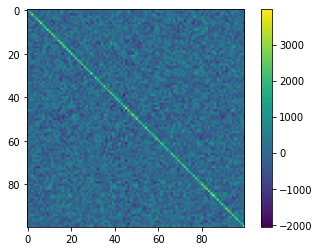

In [44]:
plt.imshow(to_np(A[1]))
plt.colorbar()

In [57]:
input_ids.repeat(2, 1).shape

torch.Size([2, 27])

In [58]:
ak = {'debug': True, 'use_pos':True}
out = model(input_ids.repeat(2,1), ak=ak)

In [59]:
ak['O'].shape

torch.Size([2, 6, 12, 27, 64])

In [245]:
alpha_avg = Ams.mean(dim=-2).mean(dim=0)
alpha_std = Ams.mean(dim=-2).std(dim=0)

Text(0, 0.5, 'Memory alpha std')

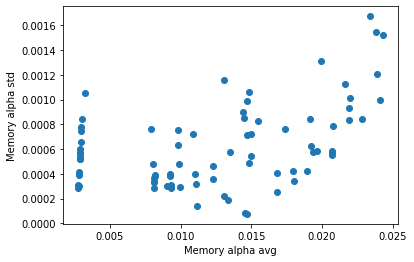

In [246]:
plt.scatter(to_np(alpha_avg), to_np(alpha_std))
plt.xlabel('Memory alpha avg')
plt.ylabel('Memory alpha std')

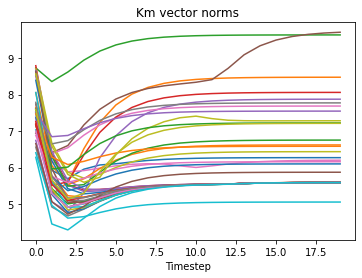

In [40]:
plt.title('Km vector norms')
plt.xlabel('Timestep')
plt.plot(Kms.norm(dim=-1).detach().cpu().numpy());

In [369]:
import something

Initializing Hopfield memories...
alpha: 1
use_adaptive_alpha: True
torch.Size([6, 1, 12, 40, 40]) torch.Size([6, 1, 12, 40, 80])


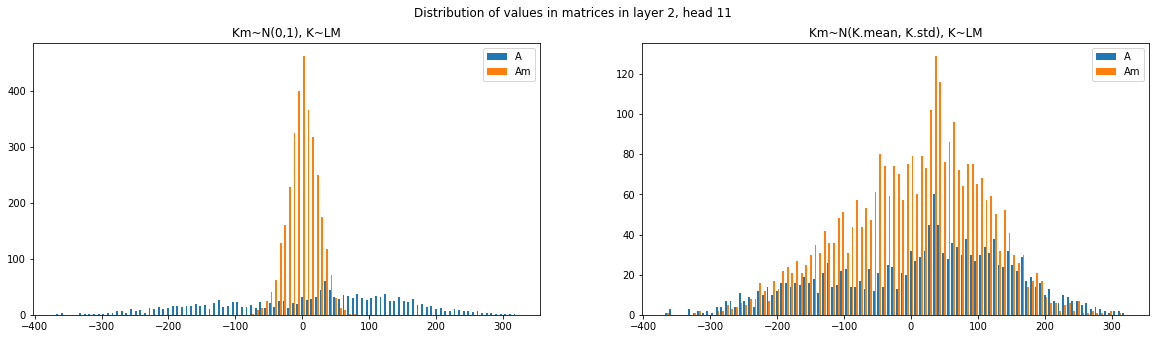

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([6, 1, 12, 40, 80]) 11


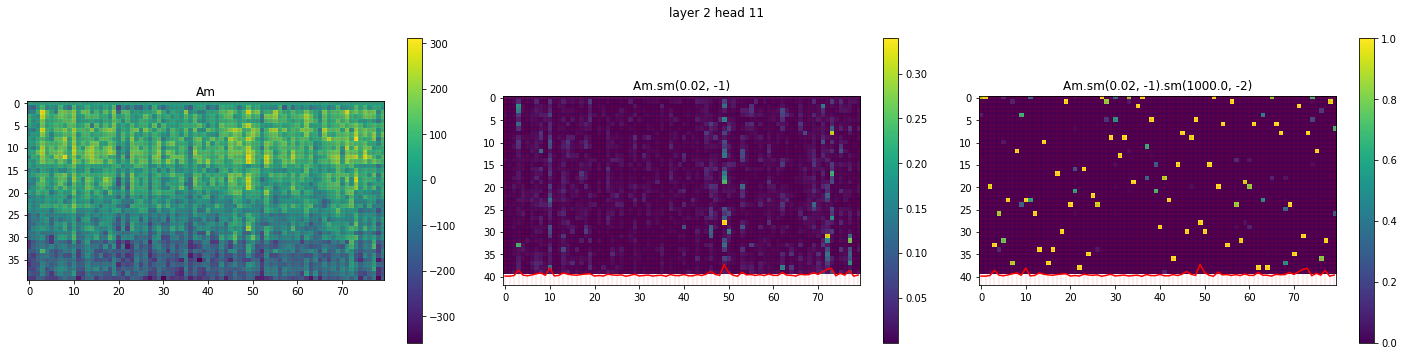

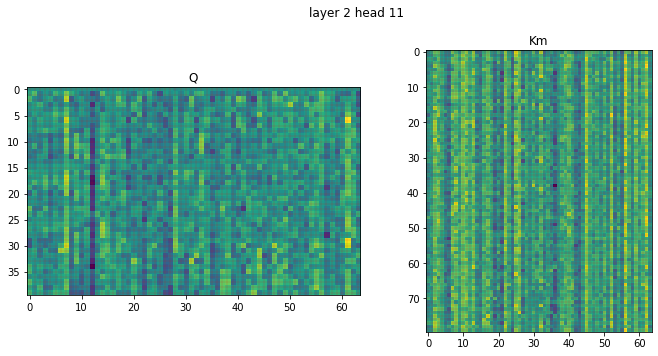

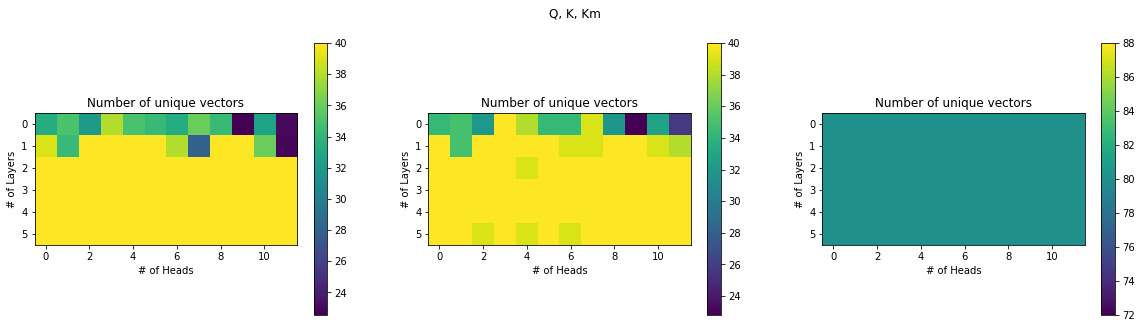

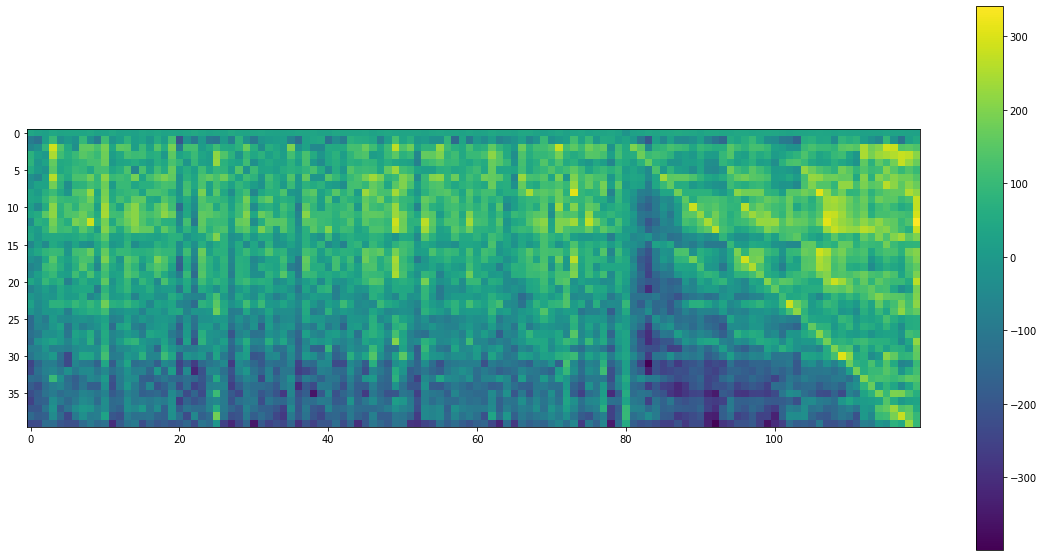

torch.Size([6, 1, 12, 40, 80]) 11


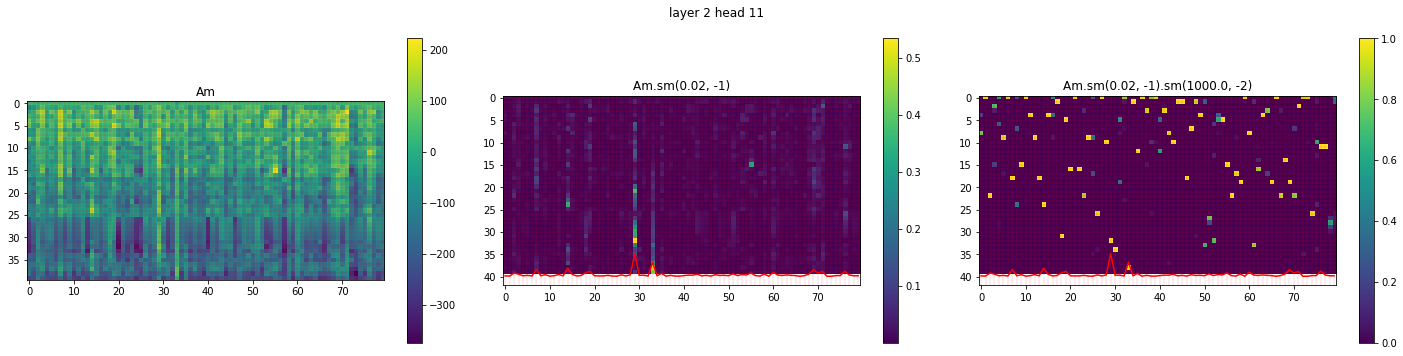

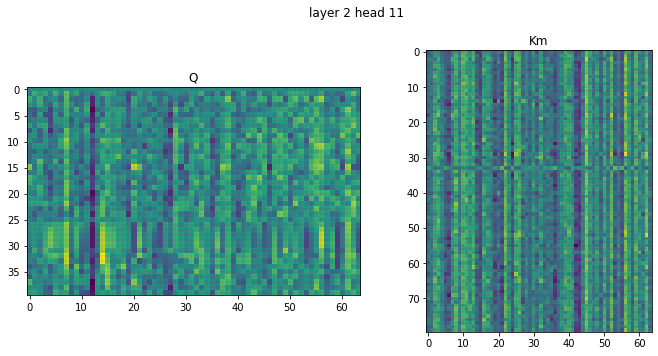

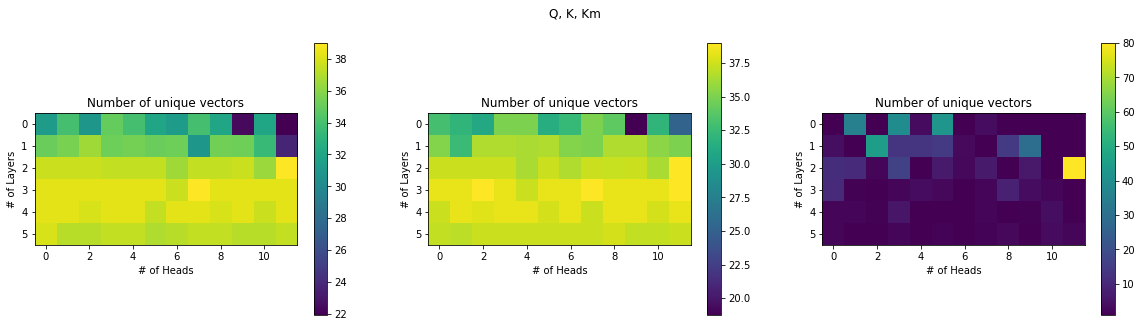

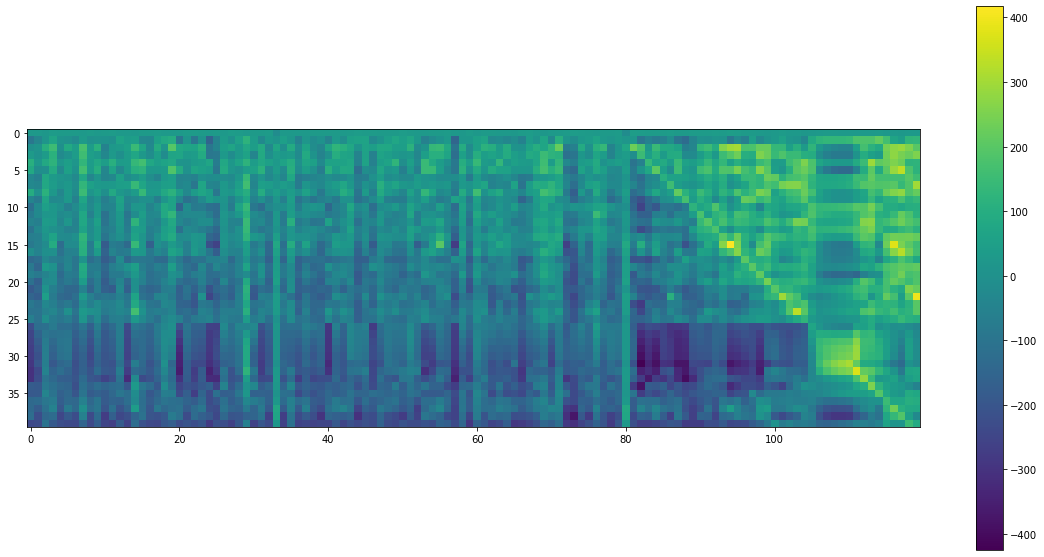

torch.Size([6, 1, 12, 40, 80]) 11


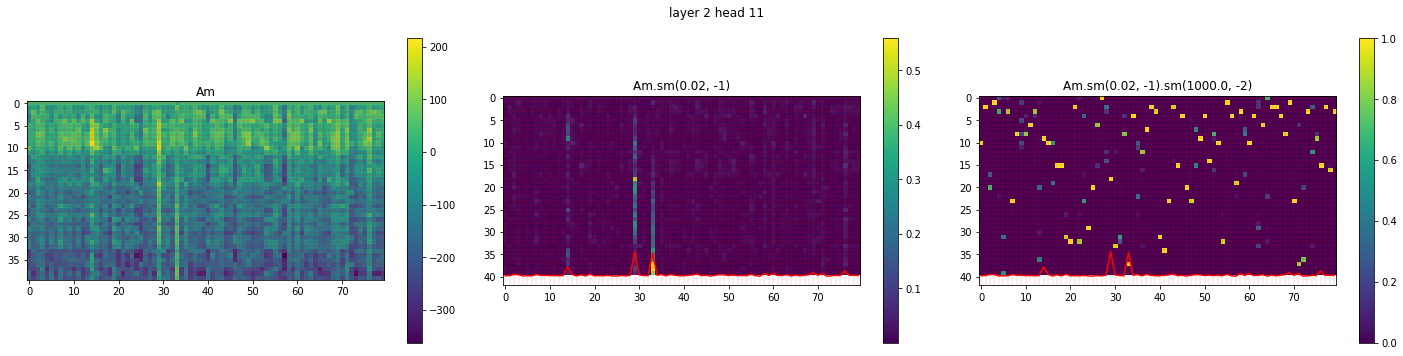

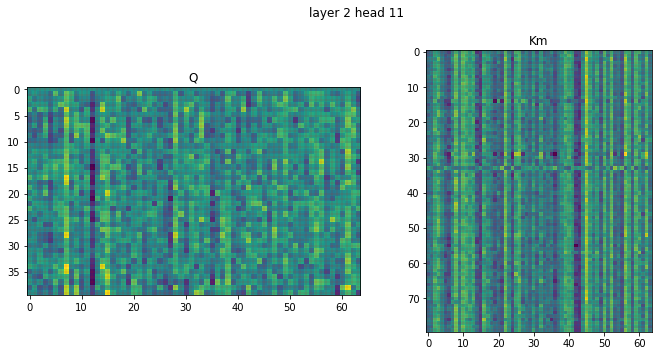

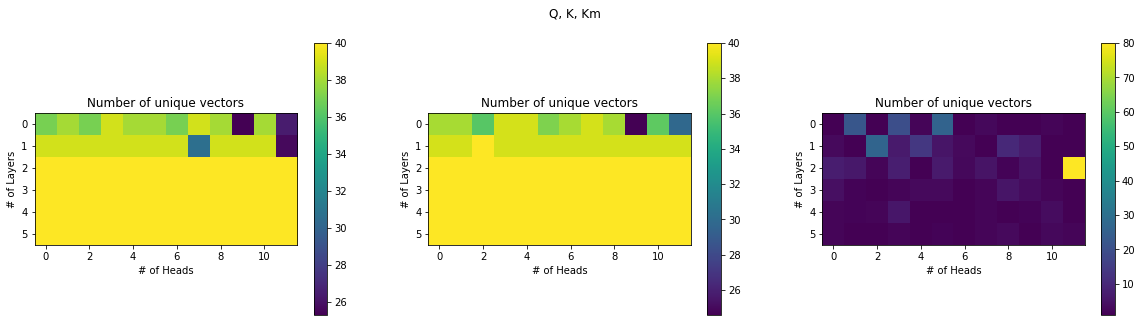

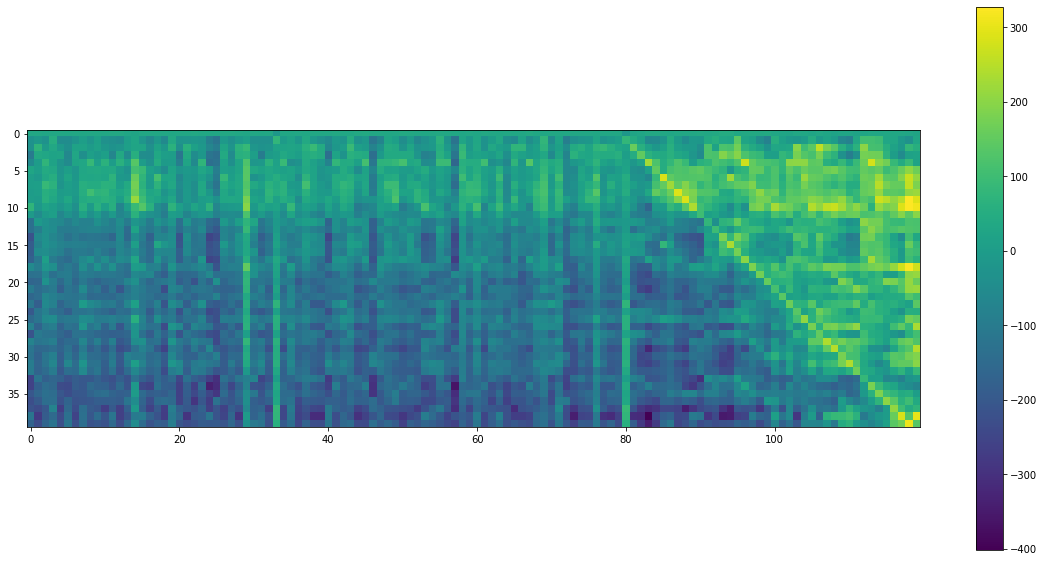

torch.Size([6, 1, 12, 40, 80]) 11


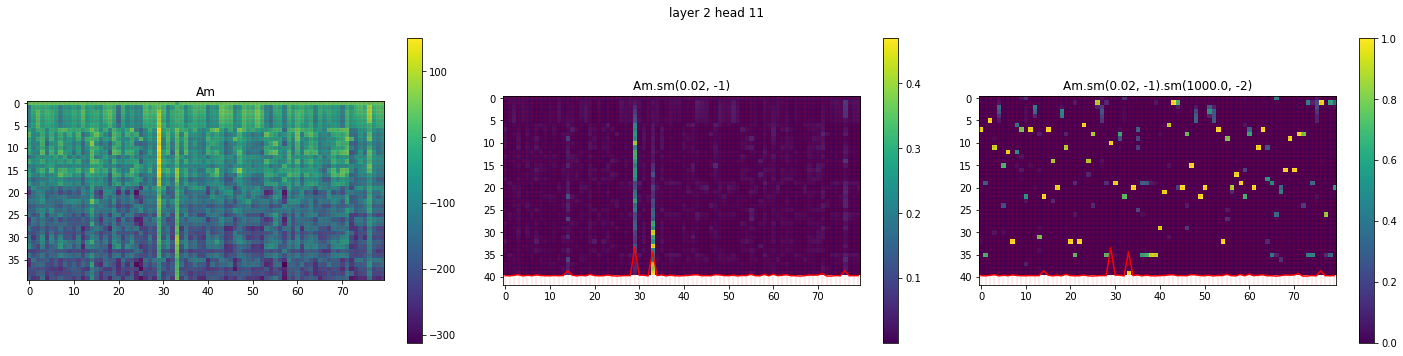

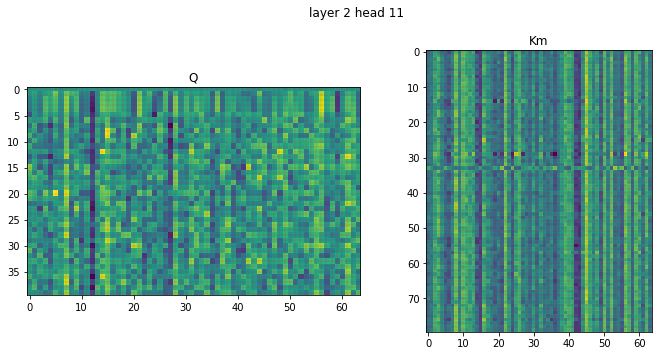

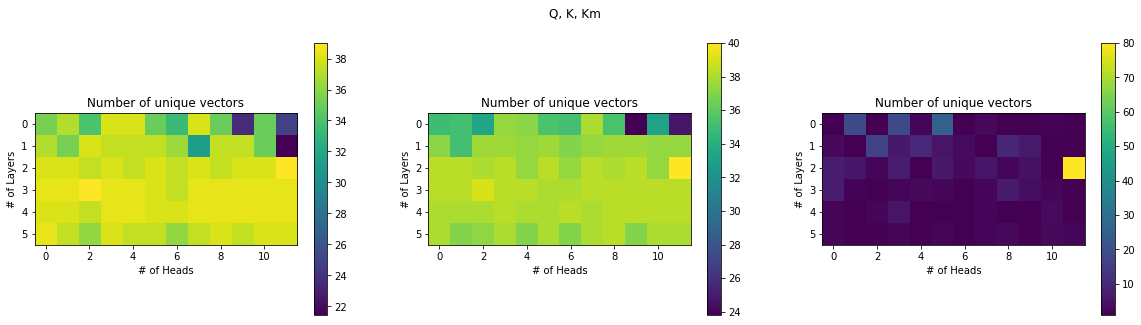

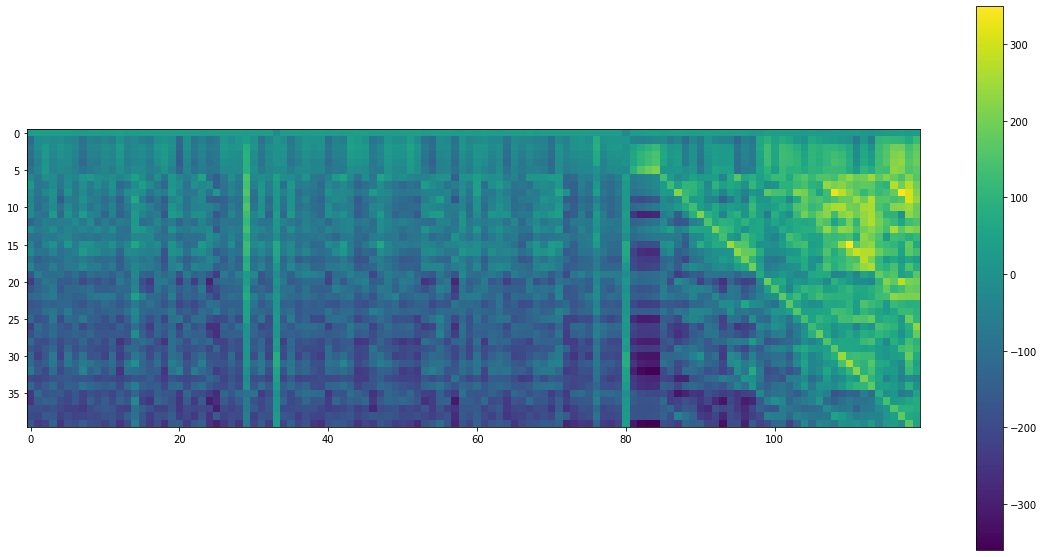

dict_keys(['idx_loop', 'tokens_context', 'nll_i', 'Km_spread', 'Q_spread', 'Am_alpha'])


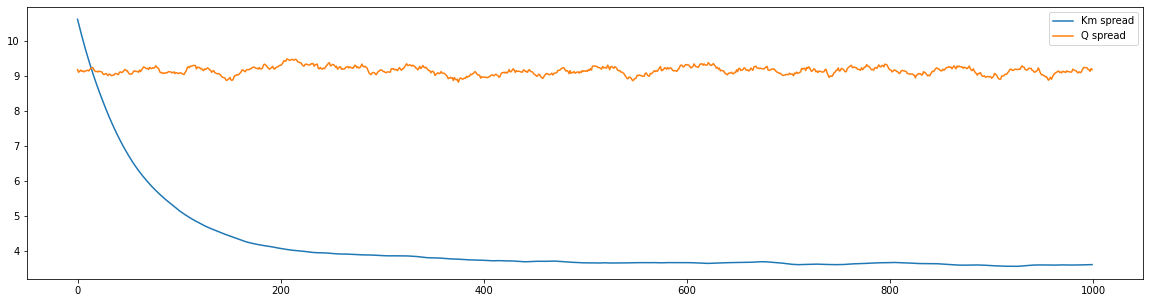

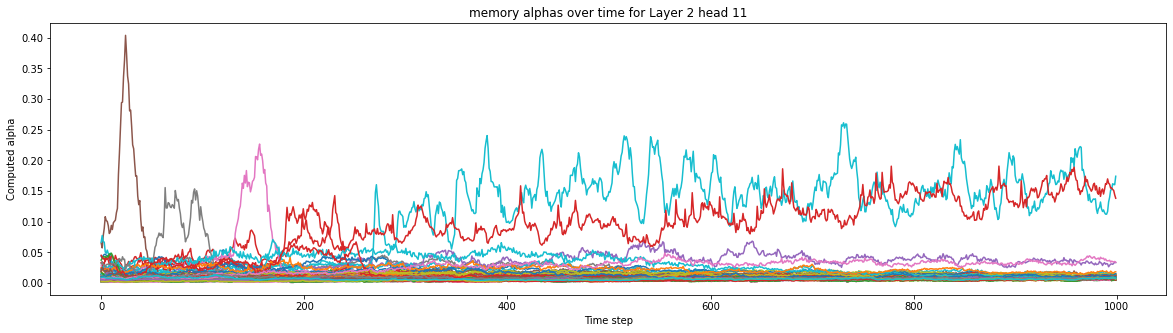

In [708]:
hm, Am, steps = something.experiment(tokenizer, model, context_length=40, device=device, tqdm=tqdm, do_viz=True)

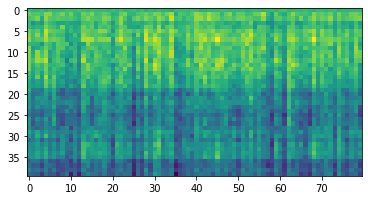

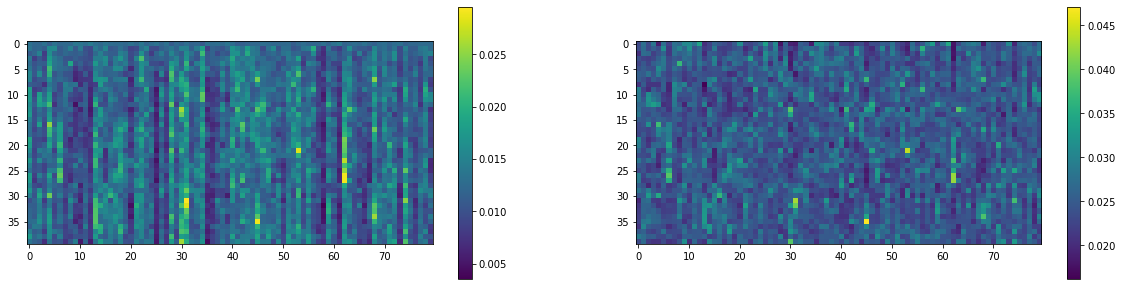

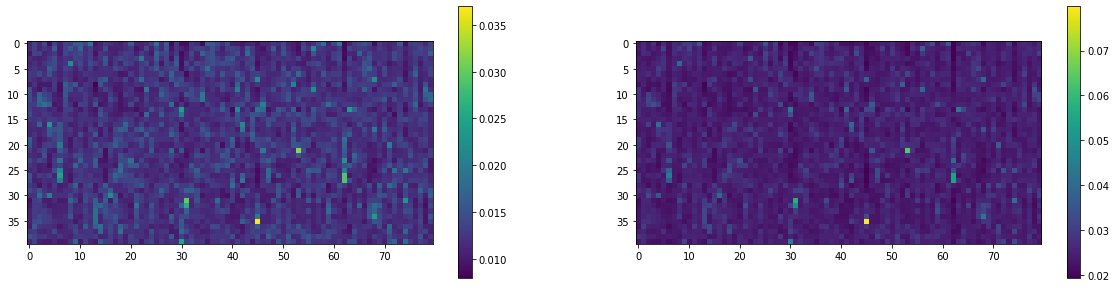

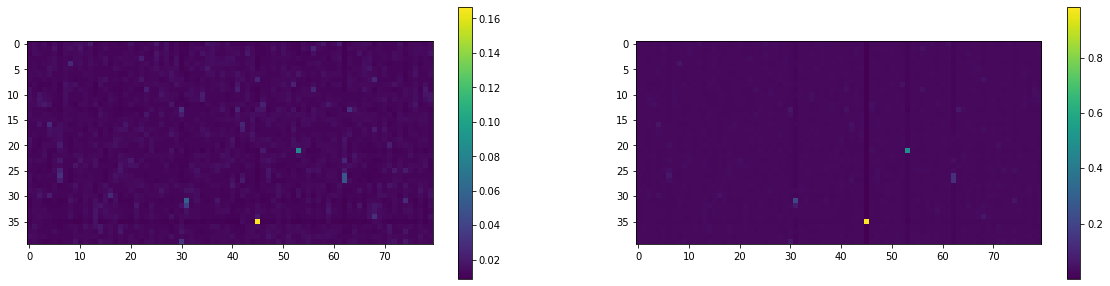

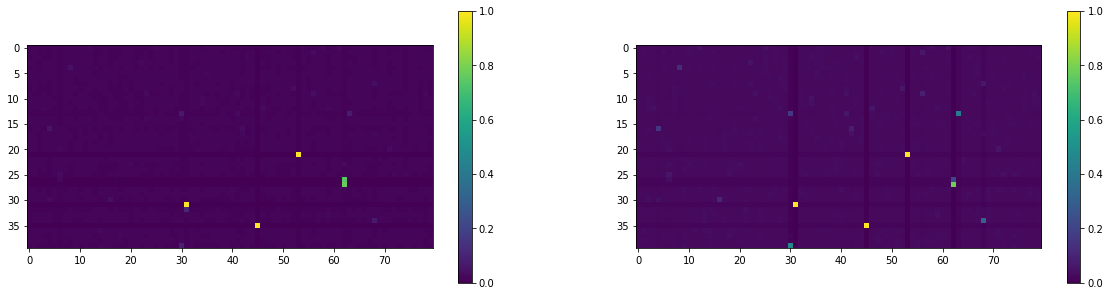

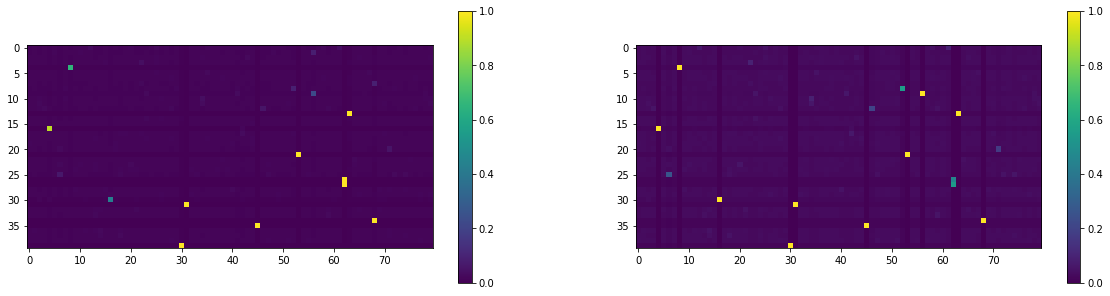

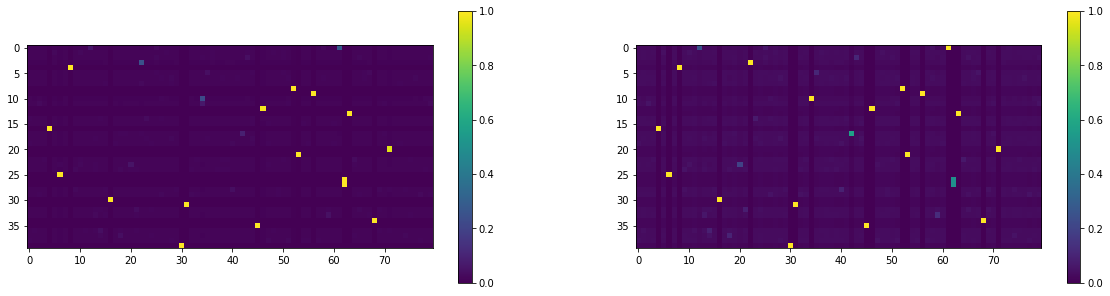

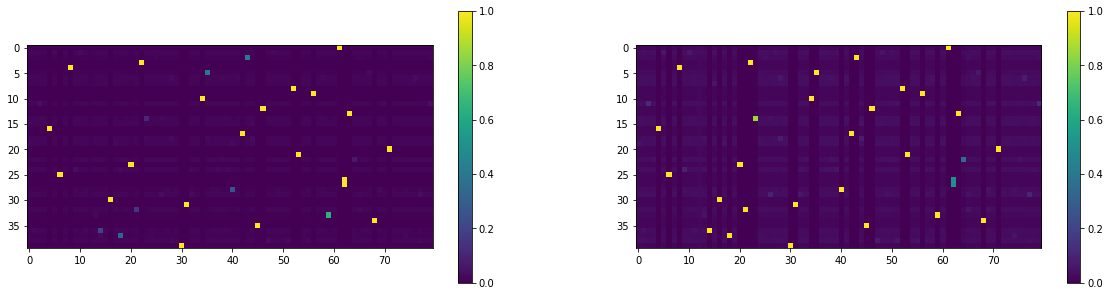

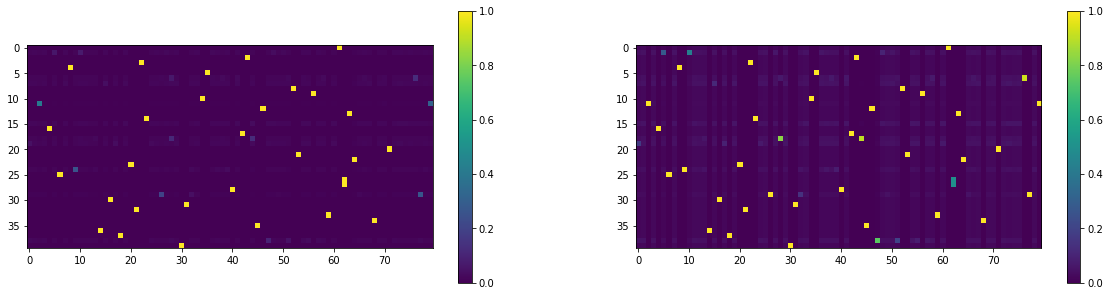

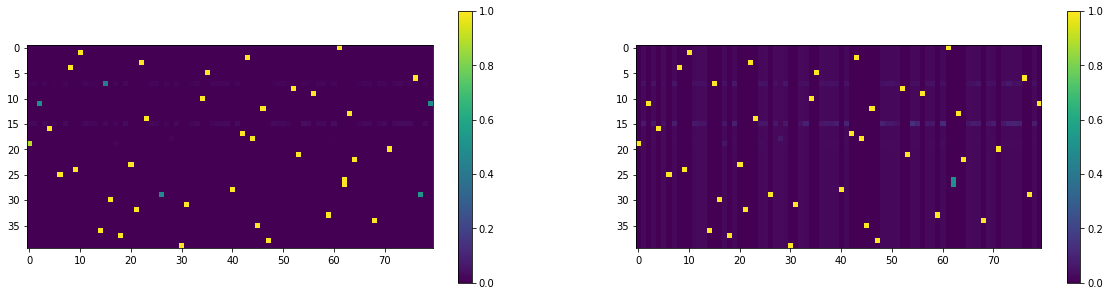

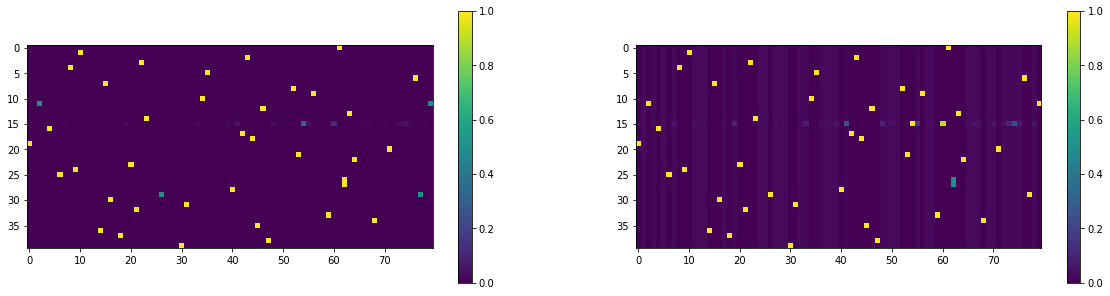

In [624]:
beta = 50
a = Am[3, 0, 0]
plt.imshow(to_np(a))
plt.show()
for i in range(10):
    plt.figure(figsize=(20, 5))
    a = sm(a, 1/50. if i==0 else beta, dim=-1)
    plt.subplot(121); plt.imshow(to_np(a)); plt.colorbar()
    a = sm(a, beta, dim=-2)
    plt.subplot(122); plt.imshow(to_np(a)); plt.colorbar()
    plt.show()


In [561]:
    

Km = torch.cat([hm.Km for hm in hms], dim=0)
a = calc_n_unique_vectors(Km)
# calc_n_unique_vectors(hms[3].Km[0, 2], do_viz_hist=True, do_viz_mat=True)

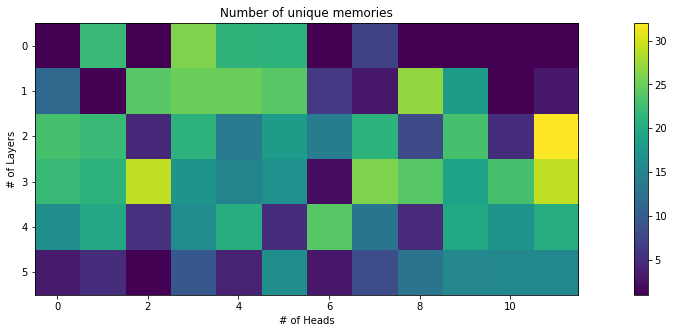

In [543]:
plt.figure(figsize=(20, 5))
plt.title("Number of unique memories")
plt.ylabel('# of Layers'); plt.xlabel('# of Heads')
plt.imshow(to_np(a)); plt.colorbar()
plt.show()